# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

#  Load Dataset

In [49]:
Data = pd.read_csv("C:\\Users\\Mahesh\\Downloads\\imdb_top_1000.csv", engine='python')

In [50]:
Data.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Description,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"2,83,41,469"
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"13,49,66,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"53,48,58,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"5,73,00,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"43,60,000"


In [52]:
Data.tail()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Description,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
995,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
996,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
997,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"3,05,00,000"
998,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN
999,The 39 Steps,1935,NaN,86 min,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,Madeleine Carroll,Lucie Mannheim,Godfrey Tearle,51853,NaN


In [53]:
Data = Data[['Series_Title', 'Genre', 'Description']]
Data.head()

,Series_Title,Genre,Description
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...


In [54]:
print(Data.describe())

       Series_Title  Genre                                        Description
count          1000   1000                                               1000
unique          999    202                                               1000
top        Drishyam  Drama  Two imprisoned men bond over a number of years...
freq              2     85                                                  1


In [55]:
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Series_Title  1000 non-null   object
 1   Genre         1000 non-null   object
 2   Description   1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None


In [56]:
print(Data.isnull().sum())

Series_Title    0
Genre           0
Description     0
dtype: int64


# EDA & Visualization

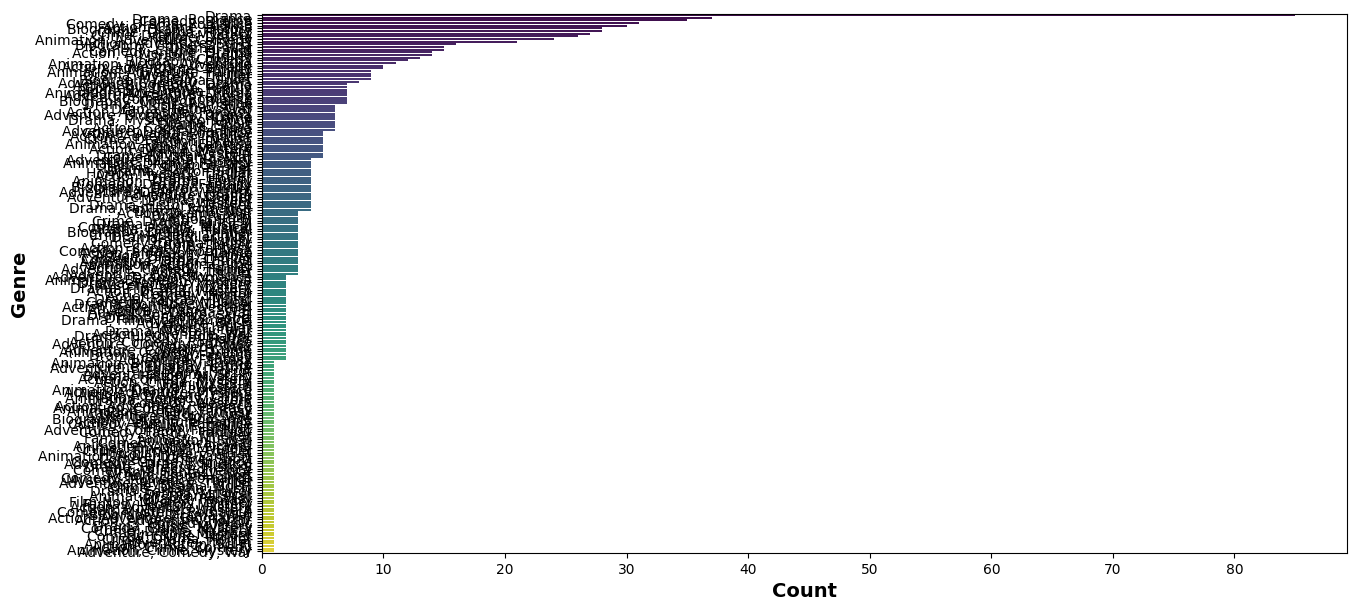

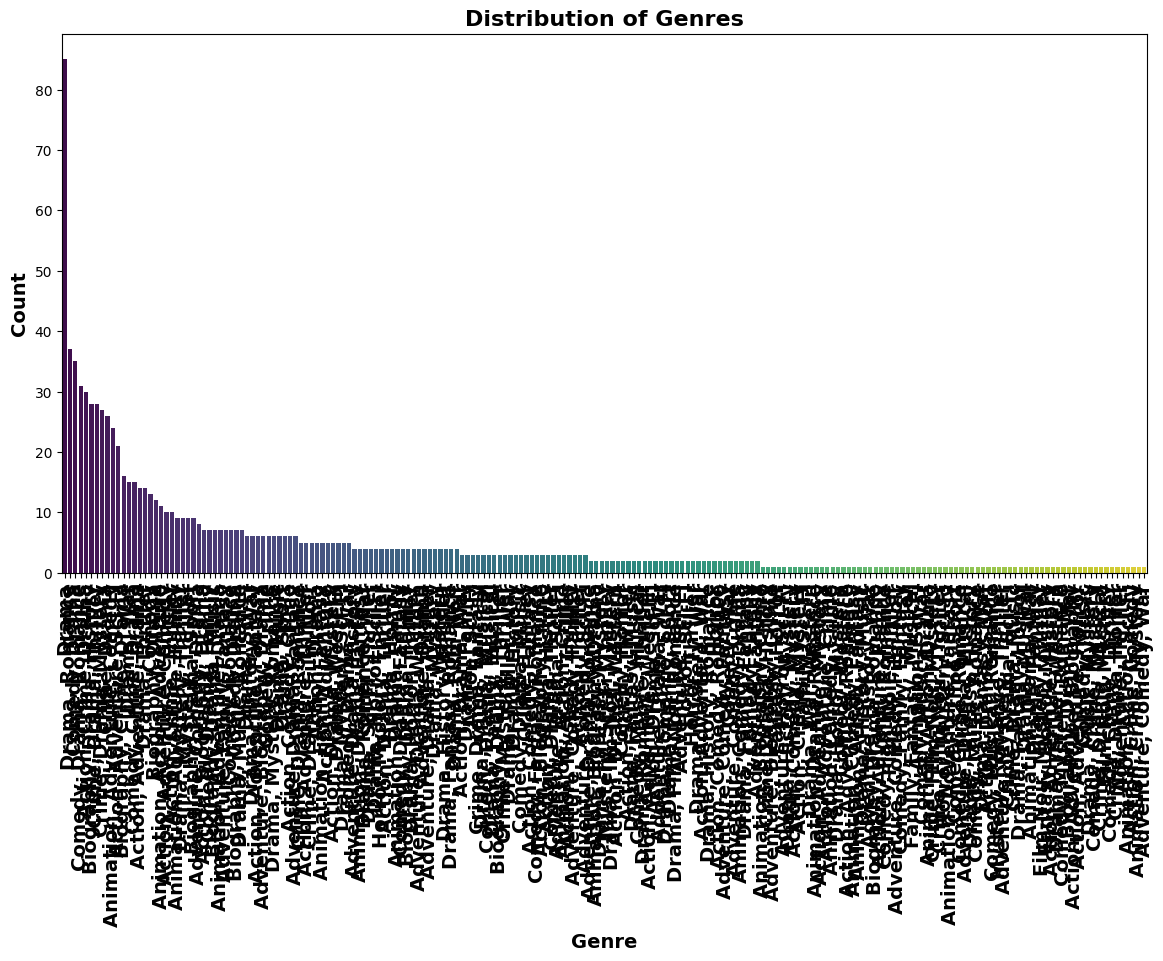

In [57]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=Data, y='Genre', order=Data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = Data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()


# Data Preprocessing and Text Cleaning

In [58]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
Data['Text_cleaning'] = Data['Description'].apply(clean_text)
Data['Text_cleaning'] = Data['Description'].apply(clean_text)

# Continue Data Preprocessing

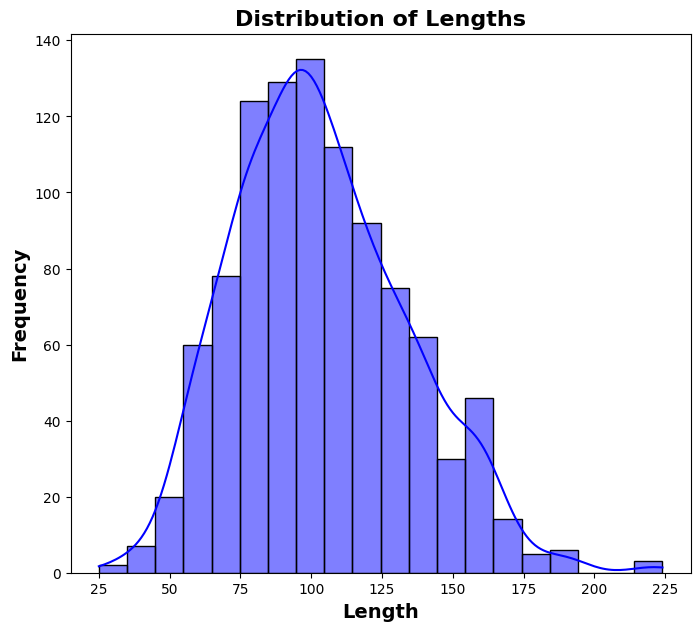

In [59]:
# Calculate the length of cleaned text
Data['length_Text_cleaning'] = Data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=Data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

# Text Vectorization Using TF-IDF

In [60]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(Data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(Data['Text_cleaning'])

# Split Data and Train a Model (Naive Bayes)

In [61]:
# Split the data into training and validation sets
X = X_train
y = Data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.075
                              precision    recall  f1-score   support

           Action, Adventure       0.00      0.00      0.00         3
    Action, Adventure, Drama       0.00      0.00      0.00         3
  Action, Adventure, Mystery       0.00      0.00      0.00         1
   Action, Adventure, Sci-Fi       0.00      0.00      0.00         7
  Action, Adventure, Western       0.00      0.00      0.00         2
    Action, Biography, Crime       0.00      0.00      0.00         1
    Action, Biography, Drama       0.00      0.00      0.00         2
       Action, Comedy, Crime       0.00      0.00      0.00         1
     Action, Comedy, Fantasy       0.00      0.00      0.00         1
        Action, Crime, Drama       0.00      0.00      0.00         3
      Action, Drama, Mystery       0.00      0.00      0.00         1
     Action, Drama, Thriller       0.00      0.00      0.00         1
      Action, Drama, Western       0.00      0.00      0.00   

C:\Users\Mahesh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahesh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahesh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Make Predictions on the Test Data

In [62]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
Data['Predicted_Genre'] = X_test_predictions

In [63]:
# Save the test_data DataFrame with predicted genres to a CSV file
Data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(Data)

                 Series_Title                     Genre  \
0    The Shawshank Redemption                     Drama   
1               The Godfather              Crime, Drama   
2             The Dark Knight      Action, Crime, Drama   
3      The Godfather: Part II              Crime, Drama   
4                12 Angry Men              Crime, Drama   
..                        ...                       ...   
995    Breakfast at Tiffany's    Comedy, Drama, Romance   
996                     Giant            Drama, Western   
997     From Here to Eternity       Drama, Romance, War   
998                  Lifeboat                Drama, War   
999              The 39 Steps  Crime, Mystery, Thriller   

                                           Description  \
0    Two imprisoned men bond over a number of years...   
1    An organized crime dynasty's aging patriarch t...   
2    When the menace known as the Joker wreaks havo...   
3    The early life and career of Vito Corleone in ...   
4